Notebook for Figures 6 and 7

In [116]:
%matplotlib inline

import tqdm

import xarray as xr
import numpy as np 

# importing the TDigest package
from crick import TDigest

#Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import cartopy.crs as ccrs

## Examining the rolling variance of the rolling mean of the temperature data

In [117]:

ds = xr.open_dataset("/work/bb1153/b382291/opa_paper_data/temp_march_2020_IFS_tco2559_ng5_cycle3_r050.nc")
ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 744, lat: 360, lon: 720)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2020-03-01 ... 2020-03-31T23:00:00
  * lat      (lat) float64 3kB -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * lon      (lon) float64 6kB 0.0 0.5 1.0 1.5 2.0 ... 358.0 358.5 359.0 359.5
Data variables:
    2t       (time, lat, lon) float64 2GB ...

Extract the dataarray

In [118]:
temp = ds['2t']

Calculate the one-pass mean but storing the output after every data chunk is passed

In [119]:
def update_mean(mean_cumulative, temp_mean, weight, count):
    # updating the cumulative mean
    mean_cumulative  = (mean_cumulative + weight * \
        (temp_mean.data - mean_cumulative) / (
        count
        ))

    return mean_cumulative

In [120]:
step = 1
count = 0
# inside the package this calculated based on the time stamp of the incoming data and the
# time step of the data, however here just setting it for convienece
n_data = np.shape(temp)[0] # 744 hours in the month

# creating an empty array to store the updated means at every time step
temp_mean_continuous = np.zeros(np.shape(temp))

for hour in range(0, len(temp.time), step):
    
    # simulating the streamed data
    data_chunk = temp.isel(time = slice(hour, hour+step))
    weight = len(data_chunk.time)

    if hour == 0:
        data_chunk_tail = data_chunk.tail(time=1)
        shape_data_chunk_tail = np.shape(data_chunk_tail)

        mean_cumulative = np.zeros(
                shape_data_chunk_tail, dtype=np.float64
            )

    count += weight
    mean_cumulative = update_mean(mean_cumulative, data_chunk, weight, count)
 
    temp_mean_continuous[hour,:,:] = mean_cumulative

Now calculating the continuous variance on the continous mean

In [121]:
count = 0
# inside the package this calculated based on the time stamp of the incoming data and the
# time step of the data, however here just setting it for convienece

# creating an empty array to store the updated variances of the continuous mean at every time step
temp_var_continuous = np.zeros(np.shape(temp))

for hour in range(0, len(temp.time), step):

    # simulating the streamed data
    data_chunk = temp_mean_continuous[hour:hour+step,:,:]
    weight = np.shape(data_chunk)[0]

    if hour == 0:
        # initialise cumulative mean and cumulative standard deviation
        mean_cumulative = np.zeros(
                shape_data_chunk_tail, dtype=np.float64
            )
        var_cumulative = np.zeros(
                shape_data_chunk_tail, dtype=np.float64
            )

    # two pass variance
    if (weight > 1):
        # two-pass mean because weight > 1 so calculate the mean over the data chunk
        ax_num = data_chunk.get_axis_num("time")
        temp_mean = np.mean(data_chunk, axis=ax_num, dtype=np.float64, keepdims=True)

        temp_var = np.var(data_chunk, axis=ax_num, dtype=np.float64, keepdims=True, ddof=1)
        temp_var = temp_var * (weight - 1)
        
        # see paper Mastelini. S for std algorithm of w > 1
        var_cumulative = (
                var_cumulative + temp_var.data
                + np.square(mean_cumulative - temp_mean.data)
                * ((count * weight) / (count + weight))
            )
        # updating the count with how many steps have been processed
        count += weight
        mean_cumulative = update_mean(mean_cumulative, temp_mean, weight, count)

    else:
        # storing 'old' mean temporarily
        old_mean = mean_cumulative
        # updating the count with how many steps have been processed
        count += weight
        mean_cumulative = update_mean(mean_cumulative, data_chunk, weight, count)

        var_cumulative = var_cumulative + weight * (
            data_chunk.data - old_mean) * (data_chunk.data - mean_cumulative)

    # using sample variance NOT population variance
    if (count - 1) != 0:
        output_var_cumulative = (
            var_cumulative / (count - 1)
        )
    else:
        output_var_cumulative = var_cumulative

    temp_var_continuous[hour, :, :] = output_var_cumulative


## Now doing the same for the wind speed data

In [122]:
ds = xr.open_dataset("/work/bb1153/b382291/opa_paper_data/wind_speed_dec_2020_IFS_tco2559_ng5_cycle3_r100.nc")
ds

<xarray.Dataset> Size: 386MB
Dimensions:                 (time: 744, lat: 180, lon: 360)
Coordinates:
  * time                    (time) datetime64[ns] 6kB 2020-12-01 ... 2020-12-...
  * lat                     (lat) float64 1kB -89.95 -88.95 ... 88.05 89.05
  * lon                     (lon) float64 3kB 0.0 1.0 2.0 ... 357.0 358.0 359.0
Data variables:
    wind_speed_rms_u10_v10  (time, lat, lon) float64 386MB ...
Attributes: (12/16)
    paramId:                    166
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    cfVarName:                  v10
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    regridded:                  1

Extract dataarray of wind speed

In [123]:
# extract data array
ws = ds.wind_speed_rms_u10_v10

In [124]:
step = 1
count = 0
# inside the package this calculated based on the time stamp of the incoming data and the
# time step of the data, however here just setting it for convienece
n_data = np.shape(ws)[0] # 744 hours in the month

# creating an empty array to store the updated means at every time step
ws_mean_continuous = np.zeros(np.shape(ws))

for hour in range(0, len(ws.time), step):
    
    # simulating the streamed data
    data_chunk = ws.isel(time = slice(hour, hour+step))
    weight = len(data_chunk.time)

    if hour == 0:
        data_chunk_tail = data_chunk.tail(time=1)
        shape_data_chunk_tail = np.shape(data_chunk_tail)

        # initialise cumulative mean
        mean_cumulative = np.zeros(
                shape_data_chunk_tail, dtype=np.float64
            )

    count += weight
    mean_cumulative = update_mean(mean_cumulative, data_chunk, weight, count)
 
    ws_mean_continuous[hour,:,:] = mean_cumulative

In [125]:
count = 0
# inside the package this calculated based on the time stamp of the incoming data and the
# time step of the data, however here just setting it for convienece

# creating an empty array to store the updated variances of the continuous mean at every time step
ws_var_continuous = np.zeros(np.shape(ws))

for hour in range(0, len(ws.time), step):

    # simulating the streamed data
    data_chunk = ws_mean_continuous[hour:hour+step,:,:]
    weight = np.shape(data_chunk)[0]

    if hour == 0:
        # initialise cumulative mean and cumulative variance
        mean_cumulative = np.zeros(
                shape_data_chunk_tail, dtype=np.float64
            )
        var_cumulative = np.zeros(
                shape_data_chunk_tail, dtype=np.float64
            )

    # two pass variance
    if (weight > 1):
        # two-pass mean because weight > 1 so calculate the mean over the data chunk
        ax_num = data_chunk.get_axis_num("time")
        temp_mean = np.mean(data_chunk, axis=ax_num, dtype=np.float64, keepdims=True)

        temp_var = np.var(data_chunk, axis=ax_num, dtype=np.float64, keepdims=True, ddof=1)
        temp_var = temp_var * (weight - 1)
        
        # see paper Mastelini. S for std algorithm of w > 1
        var_cumulative = (
                var_cumulative + temp_var.data
                + np.square(mean_cumulative - temp_mean.data)
                * ((count * weight) / (count + weight))
            )
        # updating the count with how many steps have been processed
        count += weight
        mean_cumulative = update_mean(mean_cumulative, temp_mean, weight, count)

    else:
        # storing 'old' mean temporarily
        old_mean = mean_cumulative
        # updating the count with how many steps have been processed
        count += weight
        mean_cumulative = update_mean(mean_cumulative, data_chunk, weight, count)

        var_cumulative = var_cumulative + weight * (
            data_chunk.data - old_mean) * (data_chunk.data - mean_cumulative)

    # using sample variance NOT population variance
    if (count - 1) != 0:
        output_var_cumulative = (
            var_cumulative / (count - 1)
        )
    else:
        output_var_cumulative = var_cumulative

    ws_var_continuous[hour, :, :] = output_var_cumulative


## Now looking at the 50th percentile of precipitation

In [126]:
ds = xr.open_dataset("/work/bb1153/b382291/opa_paper_data/pr_aug_2021_ICON_ngc2009_cycle3_r100.nc")
ds

<xarray.Dataset> Size: 771MB
Dimensions:  (time: 1488, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 12kB 2021-08-01 ... 2021-08-31T23:30:00
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Data variables:
    pr       (time, lat, lon) float64 771MB ...

Extracting preciptiation data and converting units

In [127]:
# extracting data array
pr = ds.pr
density = 998 # kg/m3 
pr =  (pr / density) * 1000  * 60 * 60 * 24

In [128]:

digest_list = []
grid_size = len(pr.lon)*len(pr.lat)
flat_data = np.reshape(pr.values, [len(pr.time), grid_size])

pr_50per_continuous = xr.DataArray(np.zeros(np.shape(flat_data)), dims=['time', 'grid'])
pr_50per_continuous = pr_50per_continuous.assign_coords(time=pr['time'])
[time_series, grid] = np.shape(flat_data)

Looping through the whole precipitation grid in 'streaming' mode and extracting the 50th percentile at every time step. Note this code takes approximately 4 hours to run (in serial) as the quantile estimate is being extracted after every data chunk

In [33]:
for g in tqdm.tqdm(range(grid_size)):
    for t in range(time_series):
        if t == 0:
            digest = TDigest(compression=60)
            digest.update(flat_data[t:t+1,g])
            digest_list.append(digest)
            pr_50per_continuous[t, g] = digest.quantile(0.5)
        else: 
            digest_list[g].update(flat_data[t:t+1,g])
            pr_50per_continuous[t, g] = digest.quantile(0.5)


  0%|          | 8/64800 [00:02<5:52:28,  3.06it/s]


KeyboardInterrupt: 

In [34]:
precip_np = np.reshape(pr_50per_continuous.values, [len(pr_50per_continuous.time), 
                                                   len(pr.lat), len(pr.lon)])
pr_50per_continuous = xr.DataArray(precip_np, dims=['time', 'lat', 'lon'], 
                                 coords={'time': pr.time,
                                        'lat': pr.lat,
                                        'lon': pr.lon})

Then in the same as with the continuous means, taking the continous varience of the 50th percentiles

In [130]:
count = 0

# creating an empty array to store the updated variances of the continuous 50th percentile at every time step
pr_var_continuous = np.zeros(np.shape(pr))

for half_hour in range(0, len(pr.time), step):

    # simulating the streamed data
    data_chunk = pr_50per_continuous.isel(time = slice(half_hour, half_hour+step))
    weight = np.shape(data_chunk)[0]

    if half_hour == 0:
        data_chunk_tail = data_chunk.tail(time=1)
        shape_data_chunk_tail = np.shape(data_chunk_tail)

        # initialise cumulative mean and cumulative variance
        mean_cumulative = np.zeros(
                shape_data_chunk_tail, dtype=np.float64
            )
        var_cumulative = np.zeros(
                shape_data_chunk_tail, dtype=np.float64
            )

    # two pass variance
    if (weight > 1):
        # two-pass mean because weight > 1 so calculate the mean over the data chunk
        ax_num = data_chunk.get_axis_num("time")
        temp_mean = np.mean(data_chunk, axis=ax_num, dtype=np.float64, keepdims=True)

        temp_var = np.var(data_chunk, axis=ax_num, dtype=np.float64, keepdims=True, ddof=1)
        temp_var = temp_var * (weight - 1)
        
        # see paper Mastelini. S for std algorithm of w > 1
        var_cumulative = (
                var_cumulative + temp_var.data
                + np.square(mean_cumulative - temp_mean.data)
                * ((count * weight) / (count + weight))
            )
        # updating the count with how many steps have been processed
        count += weight
        mean_cumulative = update_mean(mean_cumulative, temp_mean, weight, count)

    else:
        # storing 'old' mean temporarily
        old_mean = mean_cumulative
        # updating the count with how many steps have been processed
        count += weight
        mean_cumulative = update_mean(mean_cumulative, data_chunk, weight, count)

        var_cumulative = var_cumulative + weight * (
            data_chunk.data - old_mean) * (data_chunk.data - mean_cumulative)

    # using sample variance NOT population variance
    if (count - 1) != 0:
        output_var_cumulative = (
            var_cumulative / (count - 1)
        )
    else:
        output_var_cumulative = var_cumulative

    pr_var_continuous[half_hour, :, :] = output_var_cumulative


# Looking at convergence

Now we 6 data sets: the rollling mean of temperature and wind speed, along with the 50th percentile of precipitiaton, and the rolling variance of all of these data sets. We now to look to see how these rolling variances converege

In [131]:
# first converting all the arrays in xr.DataArrays

temp_mean_continuous = xr.DataArray(temp_mean_continuous, dims=['time', 'lat', 'lon'], 
                                 coords={'time': temp.time,
                                        'lat': temp.lat,
                                        'lon': temp.lon})

temp_var_continuous = xr.DataArray(temp_var_continuous, dims=['time', 'lat', 'lon'], 
                                 coords={'time': temp.time,
                                        'lat': temp.lat,
                                        'lon': temp.lon})

ws_mean_continuous = xr.DataArray(ws_mean_continuous, dims=['time', 'lat', 'lon'], 
                                 coords={'time': ws.time,
                                        'lat': ws.lat,
                                        'lon': ws.lon})

ws_var_continuous = xr.DataArray(ws_var_continuous, dims=['time', 'lat', 'lon'], 
                                 coords={'time': ws.time,
                                        'lat': ws.lat,
                                        'lon': ws.lon})

pr_var_continuous = xr.DataArray(pr_var_continuous, dims=['time', 'lat', 'lon'], 
                                 coords={'time': pr.time,
                                        'lat': pr.lat,
                                        'lon': pr.lon})

Starting with temperature

In [132]:
# looking for a sequence with a set CI 
start = 2 

temp_converg = xr.zeros_like(temp_var_continuous[0,:,:])
temp_converg_seq = xr.zeros_like(temp_mean_continuous[:,:,:])
less_tol = xr.zeros_like(temp_var_continuous[0,:,:])

# taking the sequence as the standard deviation
sequence = np.sqrt(temp_var_continuous[:, :, :])
temp_std = sequence

# setting the threshold and tolerance for converegence
convergence_limit = 0
tol = 0.005
threshold_up = 1 + tol
threshold_down = 1 - tol

num_conv = 20

for w in range(start, len(sequence)):

    temp_converg_seq[w-start,:,:] = abs(sequence[w, :, :] - convergence_limit)/abs(sequence[w-1, :, :] - convergence_limit)**1
    # if falls within the tolerance range add 1 
    less_tol = less_tol.where(threshold_up < temp_converg_seq[w-start,:,:], less_tol + 1, 0)
    # if falls outside of the tolerance range make it 0 
    less_tol = less_tol.where(threshold_down < temp_converg_seq[w-start,:,:], 0)
    # if it's had num_conv consecutive values within the tolerance range mark as done 
    temp_converg = temp_converg.where(temp_converg != 0, temp_converg.where(less_tol != num_conv, w))

temp_converg = temp_converg - num_conv - start

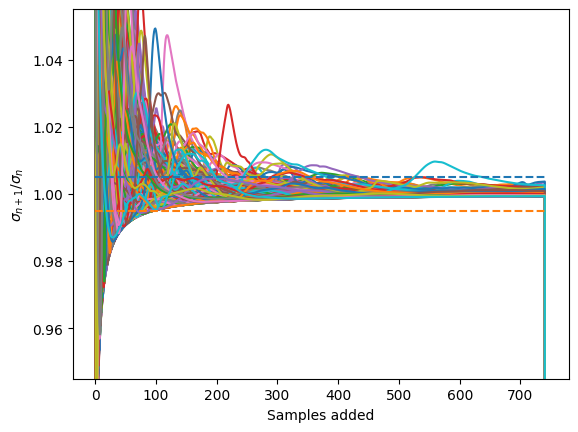

In [133]:
xaxis = np.linspace(0, len(temp_mean_continuous.time[start:]), len(temp_mean_continuous.time[start:]))

# randomly looking at some of the grid cells
for q in range(0, len(temp_var_continuous.lat), 20):
    for e in range(0, len(temp_var_continuous.lon), 50):
        plt.plot(xaxis, temp_converg_seq[start:,q,e], linestyle='-')

plt.xlabel('Samples added')
plt.plot(xaxis, np.linspace(threshold_up, threshold_up, len(temp_mean_continuous.time[start:])), linestyle='--')
plt.plot(xaxis, np.linspace(threshold_down, threshold_down, len(temp_mean_continuous.time[start:])), linestyle='--')
plt.ylabel(r'$\sigma_{n+1}/ \sigma_{n}$')
plt.ylim([threshold_down - 10*tol, threshold_up + 10*tol])
plt.show()

Doing the same analysis with the wind speed data

In [134]:
start = 2 

ws_converg = xr.zeros_like(ws_var_continuous[0,:,:])
ws_converg_seq = xr.zeros_like(ws_mean_continuous[:,:,:])
less_tol = xr.zeros_like(ws_var_continuous[0,:,:])

# taking the sequence as the standard deviation
sequence = np.sqrt(ws_var_continuous[:, :, :])
ws_std = sequence

# setting the threshold and tolerance for converegence
convergence_limit = 0
tol = 0.005
threshold_up = 1 + tol
threshold_down = 1 - tol

num_conv = 20

for w in range(start, len(sequence)):

    ws_converg_seq[w-start,:,:] = abs(sequence[w, :, :] - convergence_limit)/abs(sequence[w-1, :, :] - convergence_limit)**1
    # if falls within the tolerance range add 1 
    less_tol = less_tol.where(threshold_up < ws_converg_seq[w-start,:,:], less_tol + 1, 0)
    # if falls outside of the tolerance range make it 0
    less_tol = less_tol.where(threshold_down < ws_converg_seq[w-start,:,:], 0)
    # if it's had num_conv consecutive values within the tolerance range mark as done 
    ws_converg = ws_converg.where(ws_converg != 0, ws_converg.where(less_tol != num_conv, w))

ws_converg = ws_converg - num_conv - start

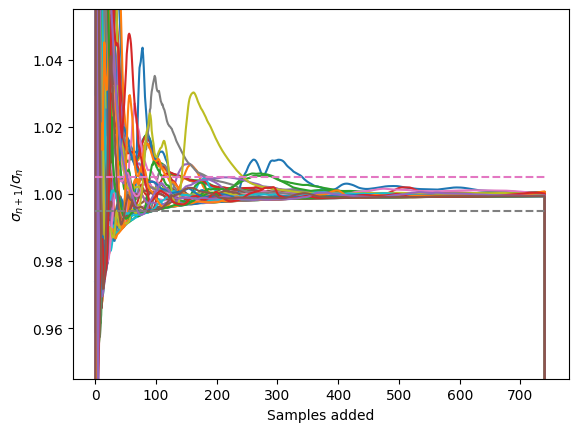

In [135]:
xaxis = np.linspace(0, len(ws_mean_continuous.time[start:]), len(ws_mean_continuous.time[start:]))

# randomly looking at some of the grid cells
for q in range(0, len(ws_var_continuous.lat), 20):
    for e in range(0, len(ws_var_continuous.lon), 100):
        plt.plot(xaxis, ws_converg_seq[start:,q,e], linestyle='-')

plt.xlabel('Samples added')
plt.plot(xaxis, np.linspace(threshold_up, threshold_up, len(ws_mean_continuous.time[start:])), linestyle='--')
plt.plot(xaxis, np.linspace(threshold_down, threshold_down, len(ws_mean_continuous.time[start:])), linestyle='--')
plt.ylabel(r'$\sigma_{n+1}/ \sigma_{n}$')
plt.ylim([threshold_down - 10*tol, threshold_up + 10*tol])
plt.show()

Finally looking at how the precipitation converges

In [136]:
start = 2 

pr_converg = xr.zeros_like(pr_var_continuous[0,:,:])
pr_converg_seq = xr.zeros_like(pr_50per_continuous[:,:,:])
less_tol = xr.zeros_like(pr_var_continuous[0,:,:])

# taking the sequence as the standard deviation
sequence = np.sqrt(pr_var_continuous[:, :, :])
pr_std = sequence

# setting the threshold and tolerance for converegence
convergence_limit = 0
tol = 0.005
threshold_up = 1 + tol
threshold_down = 1 - tol

num_conv = 20

for w in range(start, len(sequence)):

    pr_converg_seq[w-start,:,:] = abs(sequence[w, :, :] - convergence_limit)/abs(sequence[w-1, :, :] - convergence_limit)**1
    # if falls within the tolerance range add 1 
    less_tol = less_tol.where(threshold_up < pr_converg_seq[w-start,:,:], less_tol + 1, 0)
    # if falls outside of the tolerance range make it 0
    less_tol = less_tol.where(threshold_down < pr_converg_seq[w-start,:,:], 0)
    # if it's had num_conv consecutive values within the tolerance range mark as done 
    pr_converg = pr_converg.where(pr_converg != 0, pr_converg.where(less_tol != num_conv, w))

pr_converg = pr_converg - num_conv - start

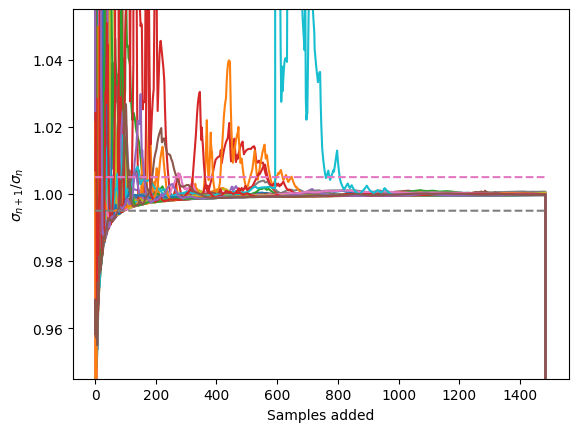

In [137]:
xaxis = np.linspace(0, len(pr_50per_continuous.time[start:]), len(pr_50per_continuous.time[start:]))

# randomly looking at some of the grid cells
for q in range(0, len(pr_var_continuous.lat), 20):
    for e in range(0, len(pr_var_continuous.lon), 100):
        plt.plot(xaxis, pr_converg_seq[start:,q,e], linestyle='-')

plt.xlabel('Samples added')
plt.plot(xaxis, np.linspace(threshold_up, threshold_up, len(pr_50per_continuous.time[start:])), linestyle='--')
plt.plot(xaxis, np.linspace(threshold_down, threshold_down, len(pr_50per_continuous.time[start:])), linestyle='--')
plt.ylabel(r'$\sigma_{n+1}/ \sigma_{n}$')
plt.ylim([threshold_down - 10*tol, threshold_up + 10*tol])
plt.show()

Creating the plot seen in the paper using the temperature data set as an example. The plots above are to show that this shape is seen across all the data sets

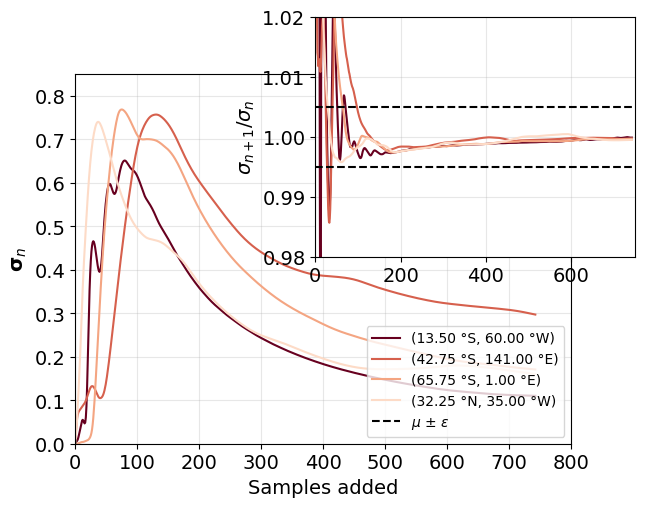

In [138]:
start = 0

# picking rando
c1 = '#67001f'
x1 = 600
y1 = 152

c2 = '#d6604d'
x2 = 282
y2 = 94

c3 = '#f4a582'
x3 = 2
y3 = 48

c4 = '#fddbc7'
x4 = 650
y4 = 250 

fs = 14 

x = [x1, x2, x3, x4]
y = [y1, y2, y3, y4]
color = [c1, c2, c3, c4]
last = -2

xaxis = np.linspace(0, len(temp_mean_continuous.time[0:last]), len(temp_mean_continuous.time[0:last]))
fig, ax1 = plt.subplots()
ax2 = fig.add_axes([0.5, 0.5, 0.5, 0.5]) 

for q in range(0, 4):
    ax2.plot(xaxis, temp_converg_seq[0:last,y[q],x[q]], linestyle='-', color = color[q])
    
for q in range(0, 4):
    if q == 0:
        ax1.plot(xaxis, temp_var_continuous[0:last,y[q],x[q]], linestyle='-', color = color[q],
                 label = '(13.50 °S, 60.00 °W)')
    if q == 1:
        ax1.plot(xaxis, temp_var_continuous[0:last,y[q],x[q]], linestyle='-', color = color[q],
                label = '(42.75 °S, 141.00 °E)')    
    if q == 2:
        ax1.plot(xaxis, temp_var_continuous[0:last,y[q],x[q]], linestyle='-', color = color[q],
                label = '(65.75 °S, 1.00 °E)')
    if q == 3:
        ax1.plot(xaxis, temp_var_continuous[0:last,y[q],x[q]], linestyle='-', color = color[q],
                label = '(32.25 °N, 35.00 °W)')
    
ax2.plot(xaxis, 
         np.linspace(threshold_up, threshold_up, len(temp_mean_continuous.time[start:last])), 
         linestyle='--', color = 'k')
ax2.plot(xaxis, 
         np.linspace(threshold_down, threshold_down, len(temp_mean_continuous.time[start:last])), 
         linestyle='--', color = 'k')

ax1.plot(np.linspace(0,0.01, 10), 
         np.linspace(0, 0.01, 10), 
         linestyle='--', color = 'k', label = r'$\mu$ $\pm$ $\epsilon$')

ax1.set_ylabel(r'$\mathbf{\sigma}_n$', fontsize = fs)
ax1.set_xlabel('Samples added', fontsize = fs)
ax1.legend(loc = 'lower right')
ax2.set_ylabel(r'$\sigma_{n+1}/ \sigma_{n}$', fontsize = fs)

ax1.tick_params(axis='y', labelcolor='black', labelsize = fs)
ax1.tick_params(axis='x', labelcolor='black', labelsize = fs)

ax2.tick_params(axis='y', labelcolor='black', labelsize = fs)
ax2.tick_params(axis='x', labelcolor='black', labelsize = fs)

ax2.grid(True, alpha = 0.3)
ax1.grid(True, alpha = 0.3)

ax1.set_xlim([0, 800])
ax1.set_ylim([0, 0.85])

ax2.set_xlim([0, 750])
ax2.set_ylim([threshold_down - tol*3, threshold_up + tol*3])

plt.show()

Final figure

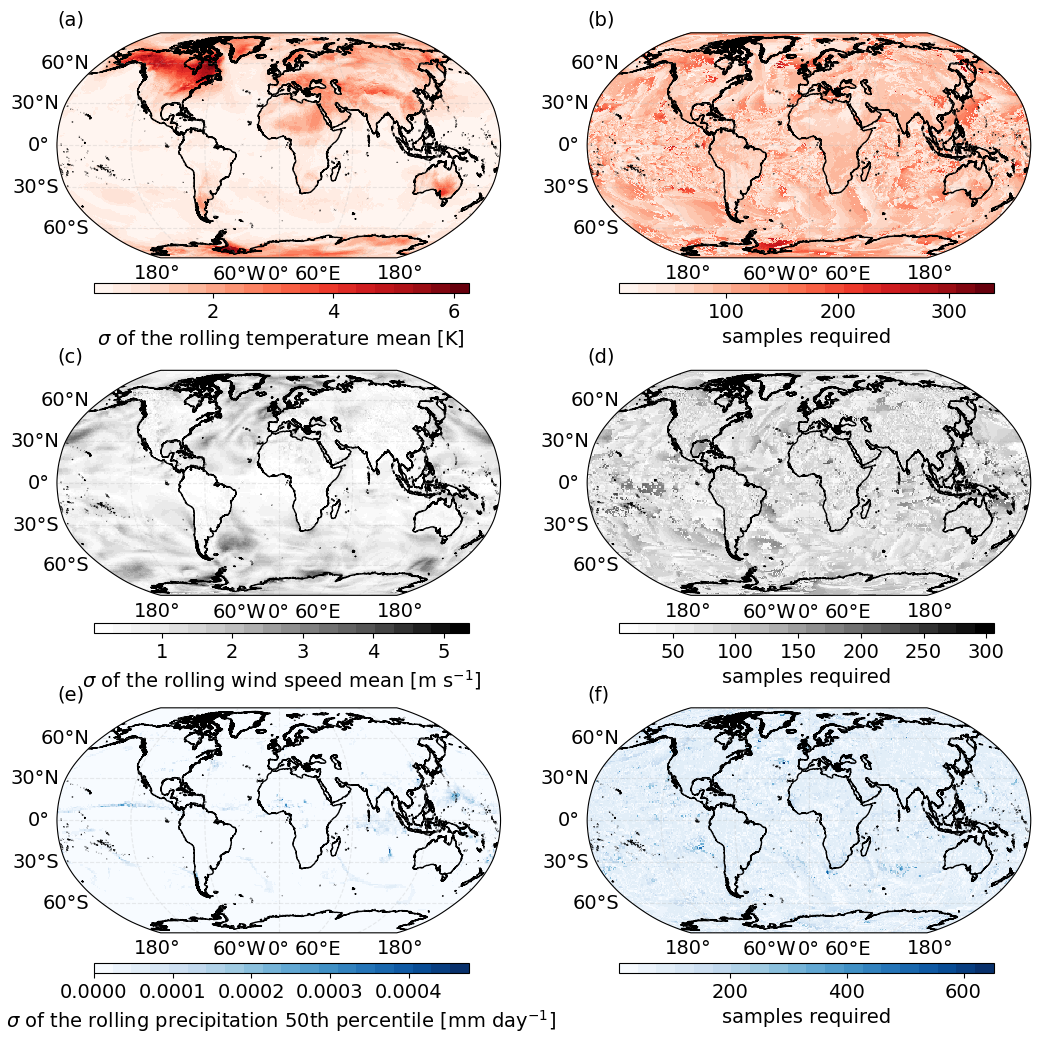

In [139]:
robinson = ccrs.Robinson()
geodetic = ccrs.Geodetic()
fig = plt.figure(constrained_layout=False, figsize=(15,10))
fig.subplots_adjust(bottom=0.05, top=0.95, left=0.15, right=0.85, wspace = 0.42, hspace = 0.05)
nrow = 3
ncol = 2
outer = gs.GridSpec(nrow,ncol,wspace=0.02,hspace=0.5, width_ratios=[1, 1])
fsize = 14
fsize_small = 10

# setting locations for the global maps
width = 0.25
left1 = 0.2
left2 = 0.55
bottom1 = 0.01
bottom2 = 0.35
bottom3 = 0.69

for i in range(nrow*ncol):
    ax = plt.subplot(outer[i],projection = robinson)
    ax.coastlines(resolution = '10m')
    gl = ax.gridlines(draw_labels = True,linestyle='dashed',alpha=0.25)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': fsize}
    gl.ylabel_style = {'size': fsize}
    lon2d,lat2d = np.meshgrid(temp_var_continuous.lon,temp_var_continuous.lat)
    lon2d_s,lat2d_s = np.meshgrid(ws_var_continuous.lon,ws_var_continuous.lat)

    if i == 0:
        
        cmap = plt.get_cmap('Reds', 20)
        cs = ax.pcolormesh(lon2d, lat2d, temp_std[-1,:,:], transform=ccrs.PlateCarree(),cmap=cmap)
        ax.set_title('(a)', fontsize=fsize, loc = 'left')
        cbar_ax = fig.add_axes([left1, bottom3, width, 0.01])
        cbar = fig.colorbar(cs,cax = cbar_ax ,orientation='horizontal')
        cbar.set_label(r"$\sigma$" " of the rolling temperature mean [K]", rotation=0, fontsize=fsize)

    elif i == 1:

        cs = ax.pcolormesh(lon2d, lat2d, temp_converg, transform=ccrs.PlateCarree(),cmap=cmap)
        ax.set_title('(b)', fontsize=fsize, loc = 'left')
        cbar_ax = fig.add_axes([left2, bottom3, width, 0.01])
        cbar = fig.colorbar(cs,cax = cbar_ax ,orientation='horizontal')
        cbar.set_label("samples required" ,rotation=0, fontsize=fsize)

    elif i == 2:
        cmap = plt.get_cmap('Grays', 20)
        
        cs = ax.pcolormesh(lon2d_s, lat2d_s, ws_std[-1,:,:], transform=ccrs.PlateCarree(),cmap=cmap)
        ax.set_title('(c)', fontsize=fsize, loc = 'left')
        cbar_ax = fig.add_axes([left1, bottom2, width, 0.01])
        cbar = fig.colorbar(cs,cax = cbar_ax ,orientation='horizontal')
        cbar.set_label(r"$\sigma$ of the rolling wind speed mean [m s$^{-1}$]" ,rotation=0, fontsize=fsize)
        
    elif i == 3:

        cs = ax.pcolormesh(lon2d_s, lat2d_s, ws_converg, transform=ccrs.PlateCarree(),cmap=cmap)
        ax.set_title('(d)', fontsize=fsize, loc = 'left')
        cbar_ax = fig.add_axes([left2, bottom2, width, 0.01])
        cbar = fig.colorbar(cs,cax = cbar_ax ,orientation='horizontal')
        cbar.set_label("samples required" ,rotation=0, fontsize=fsize)
        
    elif i == 4:
        
        cmap = plt.get_cmap('Blues', 20)
        cs = ax.pcolormesh(lon2d_s, lat2d_s, pr_std[-1,:,:], transform=ccrs.PlateCarree(),cmap=cmap)
        ax.set_title('(e)', fontsize=fsize, loc = 'left')
        cbar_ax = fig.add_axes([left1, bottom1, width, 0.01])
        cbar = fig.colorbar(cs,cax = cbar_ax ,orientation='horizontal')
        cbar.set_label(r"$\sigma$ of the rolling precipitation 50th percentile [mm day$^{-1}$]" ,rotation=0, fontsize=fsize)
        
    elif i == 5:

        cs = ax.pcolormesh(lon2d_s, lat2d_s, pr_converg, transform=ccrs.PlateCarree(),cmap=cmap)
        ax.set_title('(f)', fontsize=fsize, loc = 'left')
        cbar_ax = fig.add_axes([left2, bottom1, width, 0.01])
        cbar = fig.colorbar(cs,cax = cbar_ax ,orientation='horizontal')
        cbar.set_label("samples required" ,rotation=0, fontsize=fsize)
        
    cbar.ax.tick_params(labelsize=fsize)

plt.show()

In [140]:
np.mean(temp_converg)

<xarray.DataArray ()> Size: 8B
array(81.79863812)
Coordinates:
    time     datetime64[ns] 8B 2020-03-01

In [141]:
np.mean(ws_converg)

<xarray.DataArray ()> Size: 8B
array(77.15813272)
Coordinates:
    time     datetime64[ns] 8B 2020-12-01

In [142]:
np.mean(pr_converg)

<xarray.DataArray ()> Size: 8B
array(81.10998457)
Coordinates:
    time     datetime64[ns] 8B 2021-08-01